In [1]:
from IPython.core.display import HTML
with open ("../style.css", "r") as file:
    css = file.read()
HTML(css)

# Resolving Conflicts Using *Precedence Declarations*

This file shows how *shift/reduce* and *reduce/reduce* conflicts can be resolved using *operator precedence declarations*.
The following grammar is *ambiguous* because it does not specify the precedence of the arithmetical operators:
```
    expr : expr '+' expr
         | expr '-' expr
         | expr '*' expr
         | expr '/' expr
         | expr '^' expr
         | '(' expr ')'
         | NUMBER      
         ;
```
We will see how the use of precedence declarations can be used to resolve *shift/reduce-conflicts*.

## Specification of the Scanner

We implement a minimal scanner for arithmetic expressions.

In [2]:
import ply.lex as lex

tokens = [ 'NUMBER' ]

def t_NUMBER(t):
    r'0|[1-9][0-9]*'
    t.value = int(t.value)
    return t

literals = ['+', '-', '*', '/', '^', '(', ')']

t_ignore  = ' \t'

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count('\n')

def t_error(t):
    print(f"Illegal character '{t.value[0]}'")
    t.lexer.skip(1)

__file__ = 'main'

lexer = lex.lex()

## Specification of the Parser

In [3]:
import ply.yacc as yacc

The *start variable* of our grammar is `expr`, but we don't have to specify that.  The default
start variable is the first variable that is defined.

In [4]:
start = 'expr'

The following *operator precedence declarations* declare that the operators `'+'`and `'-'` have a lower precedence than the operators `'*'`and `'/'`.  The operator `'^'` has the highest precedence.  Furthermore, the declarations specify that the operators  `'+'`, `'-'`, `'*'`, and `'/'` are *left associative*, while the operator `'^'` is declared as *right associative* using the keyword `right`.
Operators can also be defined as being *non-associative* using the keyword `nonassoc`.

In [5]:
precedence = ( ('left', '+', '-') ,  # precedence 1
               ('left', '*', '/'),   # precedence 2
               ('right', '^')        # precedence 3
             )

In [6]:
def p_expr_plus(p):
    "expr : expr '+' expr"
    p[0] = ('+', p[1], p[3])
    
def p_expr_minus(p):
    "expr : expr '-' expr"
    p[0] = ('-', p[1], p[3])
    
def p_expr_mult(p): 
    "expr : expr '*' expr"
    p[0] = ('*', p[1], p[3])
    
def p_expr_div(p): 
    "expr : expr '/' expr"
    p[0] = ('/', p[1], p[3])    

def p_expr_power(p): 
    "expr : expr '^' expr"
    p[0] = ('^', p[1], p[3])

def p_expr_paren(p): 
    "expr : '(' expr ')'"
    p[0] = p[2]
    
def p_expr_NUMBER(p):
    "expr : NUMBER"
    p[0] = p[1]

In [7]:
def p_error(p):
    if p:
        print(f"Syntax error at character number {p.lexer.lexpos} at token '{p.value}' in line {p.lexer.lineno}.")
    else:
        print('Syntax error at end of input.')

Setting the optional argument `write_tables` to `False` <B style="color:red">is required</B> to prevent an obscure bug where the parser generator tries  to read an empty parse table.

In [8]:
parser = yacc.yacc(write_tables=False, debug=True)

Generating LALR tables


As there are no warnings all conflicts have been resolved using the precedence declarations.
Let's look at the action table that is generated.  

In [9]:
!cat parser.out

Created by PLY version 3.11 (http://www.dabeaz.com/ply)

Grammar

Rule 0     S' -> expr
Rule 1     expr -> expr + expr
Rule 2     expr -> expr - expr
Rule 3     expr -> expr * expr
Rule 4     expr -> expr / expr
Rule 5     expr -> expr ^ expr
Rule 6     expr -> ( expr )
Rule 7     expr -> NUMBER

Terminals, with rules where they appear

(                    : 6
)                    : 6
*                    : 3
+                    : 1
-                    : 2
/                    : 4
NUMBER               : 7
^                    : 5
error                : 

Nonterminals, with rules where they appear

expr                 : 1 1 2 2 3 3 4 4 5 5 6 0

Parsing method: LALR

state 0

    (0) S' -> . expr
    (1) expr -> . expr + expr
    (2) expr -> . expr - expr
    (3) expr -> . expr * expr
    (4) expr -> . expr / expr
    (5) expr -> . expr ^ expr
    (6) expr -> . ( expr )
    (7) expr -> . NUMBER

    (               shift and go to state 2
    NUMBER          shift and go to state 3



In [10]:
%run ../Chapter-07/AST-2-Dot.ipynb

The function `test(s)` takes a string `s` as its argument an tries to parse this string.  If all goes well, an abstract syntax tree is returned.
If the string can't be parsed,  an error message is printed by the parser.

In [11]:
def test(s):
    t = yacc.parse(s)
    d = tuple2dot(t)
    display(d)
    return t

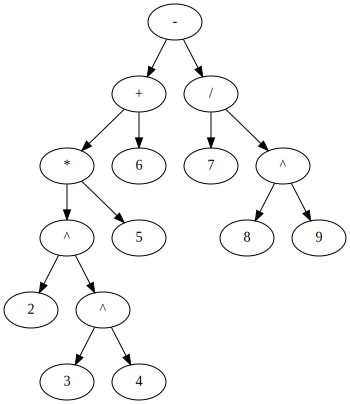

('-', ('+', ('*', ('^', 2, ('^', 3, 4)), 5), 6), ('/', 7, ('^', 8, 9)))

In [12]:
test('2^3^4*5+6-7/8^9')

In [ ]:
test('1+2*3^4')

In [ ]:
test('1 + 2 * -3^4')